# DEA WOfS and Water Classifier Notebook 

**Description:** This notebook allows users to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOfS) algorithm. The outputs of the WOfS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.

This notebook is based on a CEOS [notebook](https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb) 

The water classifier is based on [Mueller et al. (2015)](## References) [github link to water classifier code](https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py)

**Requirements:**
You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Date:__ August 2018

__Authors:__ Erin Telfer, Bex Dunn


## Import modules from standard libraries, datacube and files

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import warnings
import xarray as xr
import matplotlib as mpl

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-WOfS and water classifier')

# Import external functions from dea-notebooks
sys.path.append('../10_Scripts/')
import DEADataHandling, water_classifier_and_wofs, DEAPlotting

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

## Edit query and extract data from DEA
User input: define details below

In [2]:
#Use this to manually define an upper left/lower right coords
lat_max = -12.4 #
lat_min = -12.7
lon_max = 135.2
lon_min = 134.9 

#define temporal range
start_of_epoch = '2016-01-01'
end_of_epoch =  '2016-05-01'

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [3]:
#Query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print (query)

{'time': ('2016-01-01', '2016-05-01'), 'x': (134.9, 135.2), 'y': (-12.4, -12.7), 'crs': 'EPSG:4326'}


In [4]:
mask_dict = {'cloud_acca': 'no_cloud', 
             'cloud_fmask': 'no_cloud', 
             'cloud_shadow_acca':'no_cloud_shadow',
             'cloud_shadow_fmask':'no_cloud_shadow',
             'blue_saturated':False,
             'green_saturated':False,
             'red_saturated':False,
             'nir_saturated':False,
             'swir1_saturated':False,
             'swir2_saturated':False}

#using the load function from DEADataHandling to get the data and filter
nbart = DEADataHandling.load_clearlandsat(dc, query, 
                                          product='nbart', 
                                          masked_prop=0, 
                                          mask_dict=mask_dict)

    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 8 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


## Classify water and calculate Water Observations from Space (WOfS)

In [5]:
#Use water clasifier function 
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier_and_wofs.water_classifier(nbart)
warnings.filterwarnings('always') #turn on warnings
print(water_class)

<xarray.Dataset>
Dimensions:  (time: 8, x: 1358, y: 1337)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T01:04:21 2016-01-17T01:04:20 ...
  * y        (y) float64 -1.311e+06 -1.311e+06 -1.311e+06 -1.311e+06 ...
  * x        (x) float64 3.203e+05 3.203e+05 3.204e+05 3.204e+05 3.204e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


## Calculate and plot WOfS

In [37]:
#note, this is using only one band for the count, and this isn't robust.
total_water_obs = water_class.wofs.sum(dim='time')
nbar_count = nbart.blue.count(dim='time')
wofs = ((total_water_obs / nbar_count)*100)

## Plot WOFS

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb1ca98a90>)

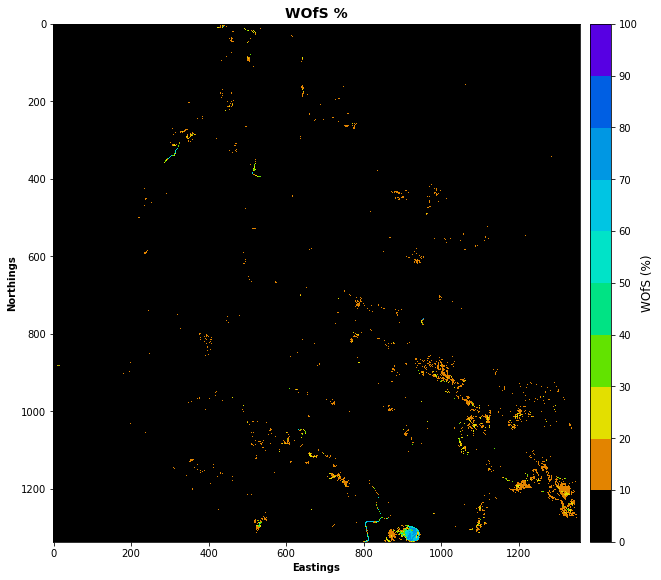

In [38]:
DEAPlotting.plot_WOfS(wofs)

## Save WOfS output to netCDF

In [40]:
DEADataHandling.write_your_netcdf(wofs, 'wofs', 'wofs_{}_{}.nc'.format(start_of_epoch,end_of_epoch), crs = nbart.crs)

## Save WOfS output to GeoTiff

In [41]:
# Convert to a dataset and restore spatial attributes
dataset = wofs.to_dataset(name='wofs')
dataset.attrs['affine'] = nbart.affine
dataset.attrs['crs']= nbart.crs

write_geotiff('wofs_{}_{}.tif'.format(start_of_epoch,end_of_epoch), dataset)

## References

1. Mueller, et al. 2015., *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. https://doi.org/10.1016/j.rse.2015.11.003
